# Q1.5 Multiple Linear Regression [16 Points]

This notebook implements multiple linear regression using all features and compares it with the simple linear regression from Q1.4.

## Imports and Data Preparation

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np


# Load dataset
df = pd.read_csv("WineQT.csv")

# All features
X_all = df.drop(columns=["quality"]).values
X_alcohol = df[["alcohol"]].values
y = df["quality"].values


## Q1.5.1 Train a multiple linear regression model using all features to predict quality using the same splits as used in previous question. Evaluate the model on the test set using MSE, RMSE, and R2.

In [20]:

def evaluate_multiple_features(X, y, n_splits=5, eta=0.01, max_iter=1000):
    results = []

    for fold in range(1, n_splits + 1):
        # Explicit 80/20 train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True, random_state=42 + fold
        )

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train SGDRegressor
        sgd = SGDRegressor(max_iter=max_iter, tol=1e-3, eta0=eta, random_state=42)
        sgd.fit(X_train_scaled, y_train)
        y_pred = sgd.predict(X_test_scaled)

        # Metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        results.append({'Fold': fold, 'MSE': mse, 'RMSE': rmse, 'R2': r2})
        print(f"Fold {fold}: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

    results_df = pd.DataFrame(results)
    print(f"\nSummary statistics (all features):")
    print(results_df[['MSE', 'RMSE', 'R2']].agg(['mean', 'std', 'min', 'max']))
    return results_df

# Evaluate multiple linear regression
results_all = evaluate_multiple_features(X_all, y)

Fold 1: MSE=0.3977, RMSE=0.6306, R²=0.3410
Fold 2: MSE=0.4259, RMSE=0.6526, R²=0.2898
Fold 3: MSE=0.4452, RMSE=0.6672, R²=0.3605
Fold 4: MSE=0.4645, RMSE=0.6815, R²=0.3012
Fold 5: MSE=0.3791, RMSE=0.6157, R²=0.3473

Summary statistics (all features):
           MSE      RMSE        R2
mean  0.422456  0.649528  0.327952
std   0.034609  0.026691  0.030747
min   0.379055  0.615675  0.289775
max   0.464476  0.681525  0.360539


## Q.1.5.2 Compare the results of simple vs multiple regression in terms of MSE, RMSE, and R²
This table represents the numbers from Q1.4 and from Q.1.5.1: 

| Model                   | Mean MSE | Mean RMSE | Mean R² |
| ----------------------- | -------- | --------- | ------- |
| Chlorides only          | 0.641    | 0.799     | 0.011   |
| Alcohol only            | 0.497    | 0.704     | 0.234   |
| All features (multiple) | 0.422    | 0.650     | 0.328   |


Multiple regression performs better than simple regression: its predictions are closer to the actual values (lower MSE and RMSE) and it explains more of the variation in wine quality (R² ≈ 0.33). Alcohol alone is moderately useful (R² ≈ 0.23), while chlorides alone adds almost no predictive power (R² ≈ 0.01). Using all features improves accuracy and fit, though the model is still too simple to capture all patterns.

## Q1.5.3 Provide comparison plots for multiple versus simple linear regression solved in pre-vious exercise. At-least one of the following plots among (i) Cost vs Iteration, (optimization) (ii) Parameter Convergence (coefficients) (iii) Predicted vs Actual (performance) and (iv) Residuals Plot (assumptions check) should be provided

I've choosen: (iii) Predicted vs Actual performance

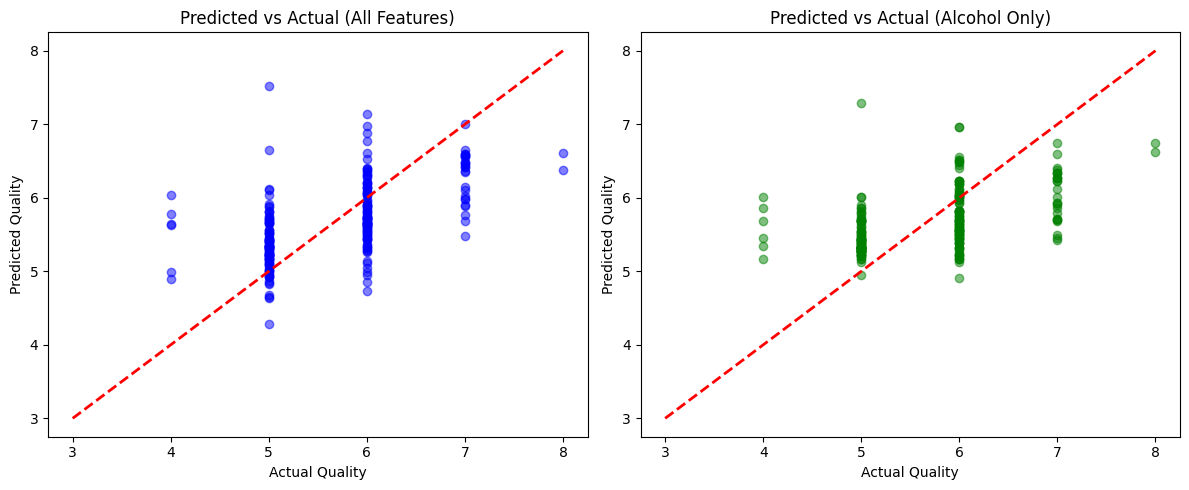

In [23]:
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Function to get predictions for a single split (80/20)
def get_predictions(X, y, eta=0.01, max_iter=1000, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=random_state
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    sgd = SGDRegressor(max_iter=max_iter, tol=1e-3, eta0=eta, random_state=42)
    sgd.fit(X_train_scaled, y_train)
    y_pred = sgd.predict(X_test_scaled)

    return y_test, y_pred

# Get predictions for multiple features
y_test_all, y_pred_all = get_predictions(X_all, y, random_state=42)

# Get predictions for alcohol-only
y_test_alc, y_pred_alc = get_predictions(X_alcohol, y, random_state=42)

# Plot Predicted vs Actual
plt.figure(figsize=(12, 5))

# Multiple regression
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, y_pred_all, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Predicted vs Actual (All Features)")

# Alcohol-only regression
plt.subplot(1, 2, 2)
plt.scatter(y_test_alc, y_pred_alc, alpha=0.5, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Predicted vs Actual (Alcohol Only)")

plt.tight_layout()
plt.show()


Above we see the plots for predicted and actual values for alcohol and multiple regression models. Each plot has points around the diagonal, indicating that the linear models only partially capture the true wine quality. The multiple regression model’s points are slightly closer to the diagonal, reflecting better predictions. This aligns with its higher R² and lower RMSE compared to the alcohol-only model. Overall, using all features improves performance, but the linear model still struggles to fully predict wine quality.

## Q1.5.4 Which model performs better and why?
Given that the multiple regression model has more to base its predictions on, its safe to assume that its a better predicator. This is reflected as well in the metrics we've used to test our models. This is shown in Q.1.5.2